# Dissertation project
## Sentimental analysis on social media data and application to finance and trading

# 1. Preparation

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn transformers torch

In [ ]:
pip install nltk


In [ ]:
pip install transformers torch


In [ ]:
pip install tqdm


In [ ]:
pip install transformers torch accelerate


In [ ]:
pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import torch
from transformers import pipeline
import re
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
from transformers import LlamaForCausalLM, LlamaTokenizer

# 2. Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
df = pd.read_csv("reduced_dataset-release.csv")

<ipython-input-9-c85a7820944c>:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("reduced_dataset-release.csv")


In [ ]:
df.head()

,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY,MENTION
0,0,RT @robertoglezcano: @amazon #Patents Show Fl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,1.000,0.0,@amazon,NaN
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1,0.0,@PayPal
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,1,0.0,@PayPal
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1,0.0,@PayPal


# 3.  Data Exploration

In [ ]:
df.info()

df.describe(include='all')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143282 entries, 0 to 143281
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         124761 non-null  object 
 1   TWEET              143279 non-null  object 
 2   STOCK              85176 non-null   object 
 3   DATE               85176 non-null   object 
 4   LAST_PRICE         85176 non-null   float64
 5   1_DAY_RETURN       85176 non-null   float64
 6   2_DAY_RETURN       85176 non-null   float64
 7   3_DAY_RETURN       85176 non-null   float64
 8   7_DAY_RETURN       85176 non-null   float64
 9   PX_VOLUME          85176 non-null   float64
 10  VOLATILITY_10D     85171 non-null   float64
 11  VOLATILITY_30D     85165 non-null   float64
 12  LSTM_POLARITY      85175 non-null   object 
 13  TEXTBLOB_POLARITY  45594 non-null   object 
 14  MENTION            27073 non-null   object 
dtypes: float64(8), object(7)
memory usage: 16.4+ MB


,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY,MENTION
count,124761,143279,85176,85176,85176.000000,85176.000000,85176.000000,8.517600e+04,8.517600e+04,8.517600e+04,85171.000000,85165.000000,85175,45594,27073
unique,85278,61030,2696,4260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,997,1406,100
top,Nike,eBay,Nike,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,@Nike
freq,8224,3726,3797,10518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14805,7878,3787
mean,NaN,NaN,NaN,NaN,229.142895,0.004375,0.007293,5.891352e+06,2.020673e+06,4.094358e+06,11.883457,7.146620,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,3227.736241,0.022527,0.032164,1.103918e+07,6.446903e+06,1.036332e+07,14.389947,12.050566,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,-0.173554,-0.177851,-0.204959,-1.778512e-01,-2.049587e-01,1.000000e+00,-1.000000,-1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,-0.000414,-0.005989,-0.009848,0.000000e+00,3.386809e-02,1.715200e+01,1.000000,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.009971,0.001119,0.003162,3.743719e-02,2.051700e+01,2.407800e+01,9.482000,0.300000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,49.972500,0.013603,0.022654,7.943443e+06,5.266800e+01,2.628128e+06,20.289000,16.026000,NaN,NaN,NaN


# 4. Data Preprocessing

In [ ]:
columns_to_drop = ['Unnamed: 0', 'LSTM_POLARITY', 'TEXTBLOB_POLARITY', 'MENTION']

In [ ]:
df = df.drop(columns=columns_to_drop)

In [ ]:
df.head()

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D
0,RT @robertoglezcano: @amazon #Patents Show Fl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,1.000
2,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099
3,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099
4,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099


In [ ]:
df = df.dropna()

In [ ]:
pattern = r'^[a-zA-Z.-]+$'

df = df[df['STOCK'].str.match(pattern, na=False)]

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'])

<ipython-input-17-755015090936>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DATE'] = pd.to_datetime(df['DATE'])


In [ ]:
unique_stocks = df['STOCK'].nunique()
unique_dates = df['DATE'].nunique()

print("Number of unique stocks:", unique_stocks)
print("Number of unique dates:", unique_dates)

Number of unique stocks: 82
Number of unique dates: 119


In [ ]:
stock_counts = df['STOCK'].value_counts()

# Count occurrences of each date
date_counts = df['DATE'].value_counts()

print("Frequency of each stock:")
print(stock_counts)

print("\nFrequency of each date:")
print(date_counts)

Frequency of each stock:
STOCK
Nike           3797
Reuters        2482
Apple          2238
eBay           2063
Netflix        1942
               ... 
Santander         6
AstraZeneca       6
Danone            5
Vodafone          4
Carrefour         2
Name: count, Length: 82, dtype: int64

Frequency of each date:
DATE
2018-09-04    1824
2018-09-13    1488
2018-09-05     988
2018-09-12     828
2018-09-06     657
              ... 
2018-07-14       4
2018-07-18       4
2018-07-23       3
2018-08-09       3
2018-08-31       1
Name: count, Length: 119, dtype: int64


In [ ]:
df.head()

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D
2,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099
3,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099
4,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099
11,"RT @nikitakhara: Thank you, @Starbucks CEO for...",Starbucks,2017-01-31,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298
20,@gawker Jamaicans make money with @Payoneer @P...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099


In [ ]:
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#', '', text)        # Remove hashtag symbol
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()                  # Convert to lowercase
    return text

df['CLEANED_TWEET'] = df['TWEET'].apply(clean_tweet)

In [ ]:
df[['TWEET', 'CLEANED_TWEET']].head()

,TWEET,CLEANED_TWEET
2,@FAME95FM1 Jamaicans make money with @Payoneer...,jamaicans make money with and \r
3,@CBSi Jamaicans make money with @Payoneer @Pay...,jamaicans make money with and \r
4,@Hitz92fm Jamaicans make money with @Payoneer ...,jamaicans make money with and \r
11,"RT @nikitakhara: Thank you, @Starbucks CEO for...",rt thank you ceo for committing to hire 1000...
20,@gawker Jamaicans make money with @Payoneer @P...,jamaicans make money with and \r


# 5. Calculating Polarity

## 5.1 NLP Calculation

### 5.1.1 Textblob

In [ ]:
def get_textblob_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the cleaned tweets
df['TEXTBLOB_POLARITY'] = df['CLEANED_TWEET'].apply(get_textblob_polarity)

# Check the first few rows with polarity
df[['CLEANED_TWEET', 'TEXTBLOB_POLARITY']].head()

,CLEANED_TWEET,TEXTBLOB_POLARITY
2,jamaicans make money with and \r,0.0
3,jamaicans make money with and \r,0.0
4,jamaicans make money with and \r,0.0
11,rt thank you ceo for committing to hire 1000...,0.2
20,jamaicans make money with and \r,0.0


In [ ]:
Textblob_counts = df['TEXTBLOB_POLARITY'].value_counts()

print("Frequency of each polarity:")
print(Textblob_counts)

Frequency of each polarity:
TEXTBLOB_POLARITY
 0.000000    11138
 0.500000     1195
 0.136364      604
 0.200000      571
 0.400000      455
             ...  
 0.378788        1
 0.483333        1
-0.238095        1
 0.725000        1
-0.329167        1
Name: count, Length: 1247, dtype: int64


### 5.1.2 VADER

In [ ]:
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def get_vader_polarity(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']  # 'compound' is a normalized score between -1 and +1

# Apply the function to your cleaned tweets
df['VADER_POLARITY'] = df['CLEANED_TWEET'].apply(get_vader_polarity)

# Check the results
df[['CLEANED_TWEET', 'VADER_POLARITY']].head()

,CLEANED_TWEET,VADER_POLARITY
2,jamaicans make money with and \r,0.0000
3,jamaicans make money with and \r,0.0000
4,jamaicans make money with and \r,0.0000
11,rt thank you ceo for committing to hire 1000...,0.6908
20,jamaicans make money with and \r,0.0000


In [ ]:
VADER_counts = df['VADER_POLARITY'].value_counts()

print("Frequency of each polarity:")
print(VADER_counts)

Frequency of each polarity:
VADER_POLARITY
 0.0000    8340
 0.3612     476
 0.4019     474
 0.4215     392
 0.3182     389
           ... 
 0.3902       1
-0.0689       1
 0.9313       1
-0.8805       1
-0.2272       1
Name: count, Length: 1346, dtype: int64


## 5.2 LLM Calculation

### 5.2.1 BERT - Based Model

In [ ]:
sentiment_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
def get_bert_polarity(text):
    result = sentiment_pipeline(text)[0]
    # Return +1 for 'POSITIVE', -1 for 'NEGATIVE', and 0 for neutral
    if result['label'] == 'POSITIVE':
        return result['score']  # positive polarity
    else:
        return -result['score']  # negative polarity


In [ ]:
tqdm.pandas()

In [ ]:
df['BERT_POLARITY'] = df['CLEANED_TWEET'].progress_apply(get_bert_polarity)

df[['CLEANED_TWEET', 'BERT_POLARITY']].head()

100%|██████████| 25153/25153 [10:36<00:00, 39.49it/s]


,CLEANED_TWEET,BERT_POLARITY
2,jamaicans make money with and \r,0.985803
3,jamaicans make money with and \r,0.985803
4,jamaicans make money with and \r,0.985803
11,rt thank you ceo for committing to hire 1000...,0.884282
20,jamaicans make money with and \r,0.985803


In [ ]:
BERT_counts = df['BERT_POLARITY'].value_counts()

print("Frequency of each polarity:")
print(BERT_counts)

Frequency of each polarity:
BERT_POLARITY
-0.948971    974
-0.985907    150
-0.994391    134
-0.996395    132
 0.994826    128
            ... 
-0.980242      1
-0.623303      1
 0.983019      1
-0.995944      1
-0.976950      1
Name: count, Length: 15541, dtype: int64


In [ ]:
df.head()

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,CLEANED_TWEET,TEXTBLOB_POLARITY,VADER_POLARITY,BERT_POLARITY
2,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,jamaicans make money with and \r,0.0,0.0000,0.985803
3,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,jamaicans make money with and \r,0.0,0.0000,0.985803
4,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,jamaicans make money with and \r,0.0,0.0000,0.985803
11,"RT @nikitakhara: Thank you, @Starbucks CEO for...",Starbucks,2017-01-31,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,rt thank you ceo for committing to hire 1000...,0.2,0.6908,0.884282
20,@gawker Jamaicans make money with @Payoneer @P...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,jamaicans make money with and \r,0.0,0.0000,0.985803


# 6. experiment with the scores

In [ ]:
import pandas as pd

# Assume you have a DataFrame 'df' with polarity scores and stock returns

# Create a binary label for sentiment polarity
# 1 for positive polarity (>= 0), 0 for negative polarity (< 0)
df['BERT_POLARITY_SIGN'] = df['BERT_POLARITY'].apply(lambda x: 1 if x >= 0 else 0)
df['VADER_POLARITY_SIGN'] = df['VADER_POLARITY'].apply(lambda x: 1 if x >= 0 else 0)
df['TEXTBLOB_POLARITY_SIGN'] = df['TEXTBLOB_POLARITY'].apply(lambda x: 1 if x >= 0 else 0)

# Create a binary label for stock returns
# 1 for positive return (> 0), 0 for negative or no return (<= 0)
df['1_DAY_RETURN_SIGN'] = df['1_DAY_RETURN'].apply(lambda x: 1 if x > 0 else 0)
df['3_DAY_RETURN_SIGN'] = df['3_DAY_RETURN'].apply(lambda x: 1 if x > 0 else 0)
df['7_DAY_RETURN_SIGN'] = df['7_DAY_RETURN'].apply(lambda x: 1 if x > 0 else 0)


In [ ]:
# Compare signs for 1-day return
matches_bert_1_day = (df['BERT_POLARITY_SIGN'] == df['1_DAY_RETURN_SIGN']).mean()
matches_vader_1_day = (df['VADER_POLARITY_SIGN'] == df['1_DAY_RETURN_SIGN']).mean()
matches_textblob_1_day = (df['TEXTBLOB_POLARITY_SIGN'] == df['1_DAY_RETURN_SIGN']).mean()

# Print the percentage of matches for each model (BERT, VADER, TextBlob)
print(f"BERT polarity matches 1-day return direction: {matches_bert_1_day * 100:.2f}%")
print(f"VADER polarity matches 1-day return direction: {matches_vader_1_day * 100:.2f}%")
print(f"TextBlob polarity matches 1-day return direction: {matches_textblob_1_day * 100:.2f}%")

# Repeat the comparison for 3-day and 7-day returns
matches_bert_3_day = (df['BERT_POLARITY_SIGN'] == df['3_DAY_RETURN_SIGN']).mean()
matches_vader_3_day = (df['VADER_POLARITY_SIGN'] == df['3_DAY_RETURN_SIGN']).mean()
matches_textblob_3_day = (df['TEXTBLOB_POLARITY_SIGN'] == df['3_DAY_RETURN_SIGN']).mean()

matches_bert_7_day = (df['BERT_POLARITY_SIGN'] == df['7_DAY_RETURN_SIGN']).mean()
matches_vader_7_day = (df['VADER_POLARITY_SIGN'] == df['7_DAY_RETURN_SIGN']).mean()
matches_textblob_7_day = (df['TEXTBLOB_POLARITY_SIGN'] == df['7_DAY_RETURN_SIGN']).mean()

print(f"BERT polarity matches 3-day return direction: {matches_bert_3_day * 100:.2f}%")
print(f"VADER polarity matches 3-day return direction: {matches_vader_3_day * 100:.2f}%")
print(f"TextBlob polarity matches 3-day return direction: {matches_textblob_3_day * 100:.2f}%")

print(f"BERT polarity matches 7-day return direction: {matches_bert_7_day * 100:.2f}%")
print(f"VADER polarity matches 7-day return direction: {matches_vader_7_day * 100:.2f}%")
print(f"TextBlob polarity matches 7-day return direction: {matches_textblob_7_day * 100:.2f}%")


BERT polarity matches 1-day return direction: 52.98%
VADER polarity matches 1-day return direction: 46.35%
TextBlob polarity matches 1-day return direction: 45.66%
BERT polarity matches 3-day return direction: 48.47%
VADER polarity matches 3-day return direction: 53.21%
TextBlob polarity matches 3-day return direction: 54.53%
BERT polarity matches 7-day return direction: 48.74%
VADER polarity matches 7-day return direction: 51.91%
TextBlob polarity matches 7-day return direction: 54.12%


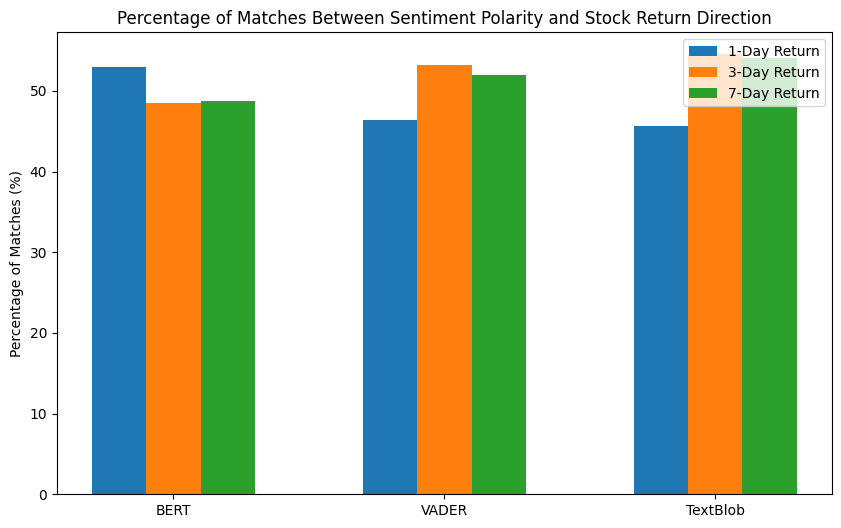

In [ ]:
import matplotlib.pyplot as plt

# Create a list of match percentages for 1-day return
match_1_day = [matches_bert_1_day * 100, matches_vader_1_day * 100, matches_textblob_1_day * 100]
match_3_day = [matches_bert_3_day * 100, matches_vader_3_day * 100, matches_textblob_3_day * 100]
match_7_day = [matches_bert_7_day * 100, matches_vader_7_day * 100, matches_textblob_7_day * 100]

# Create a bar plot
models = ['BERT', 'VADER', 'TextBlob']
x = range(len(models))

plt.figure(figsize=(10, 6))

# Bar plot for 1-day, 3-day, and 7-day match percentages
plt.bar(x, match_1_day, width=0.2, label='1-Day Return', align='center')
plt.bar([i + 0.2 for i in x], match_3_day, width=0.2, label='3-Day Return', align='center')
plt.bar([i + 0.4 for i in x], match_7_day, width=0.2, label='7-Day Return', align='center')

# Formatting the plot
plt.xticks([i + 0.2 for i in x], models)
plt.ylabel('Percentage of Matches (%)')
plt.title('Percentage of Matches Between Sentiment Polarity and Stock Return Direction')
plt.legend()

plt.show()


In [ ]:
# Correlation for BERT polarity
correlation_bert_1_day = df['BERT_POLARITY'].corr(df['1_DAY_RETURN'])
correlation_bert_3_day = df['BERT_POLARITY'].corr(df['3_DAY_RETURN'])
correlation_bert_7_day = df['BERT_POLARITY'].corr(df['7_DAY_RETURN'])

# Correlation for TextBlob polarity
correlation_textblob_1_day = df['TEXTBLOB_POLARITY'].corr(df['1_DAY_RETURN'])
correlation_textblob_3_day = df['TEXTBLOB_POLARITY'].corr(df['3_DAY_RETURN'])
correlation_textblob_7_day = df['TEXTBLOB_POLARITY'].corr(df['7_DAY_RETURN'])

# Correlation for VADER polarity
correlation_vader_1_day = df['VADER_POLARITY'].corr(df['1_DAY_RETURN'])
correlation_vader_3_day = df['VADER_POLARITY'].corr(df['3_DAY_RETURN'])
correlation_vader_7_day = df['VADER_POLARITY'].corr(df['7_DAY_RETURN'])

# Print the correlation values for comparison
print(f"BERT 1-Day Return Correlation: {correlation_bert_1_day}")
print(f"BERT 3-Day Return Correlation: {correlation_bert_3_day}")
print(f"BERT 7-Day Return Correlation: {correlation_bert_7_day}")

print(f"TextBlob 1-Day Return Correlation: {correlation_textblob_1_day}")
print(f"TextBlob 3-Day Return Correlation: {correlation_textblob_3_day}")
print(f"TextBlob 7-Day Return Correlation: {correlation_textblob_7_day}")

print(f"VADER 1-Day Return Correlation: {correlation_vader_1_day}")
print(f"VADER 3-Day Return Correlation: {correlation_vader_3_day}")
print(f"VADER 7-Day Return Correlation: {correlation_vader_7_day}")



BERT 1-Day Return Correlation: 0.021036441197453095
BERT 3-Day Return Correlation: 0.044836444268076495
BERT 7-Day Return Correlation: 0.03385115617841457
TextBlob 1-Day Return Correlation: 0.006727028668561253
TextBlob 3-Day Return Correlation: 0.02491099787524547
TextBlob 7-Day Return Correlation: 0.0471116378921979
VADER 1-Day Return Correlation: 0.0092158935394132
VADER 3-Day Return Correlation: 0.007967838088985657
VADER 7-Day Return Correlation: 0.030249421457070262


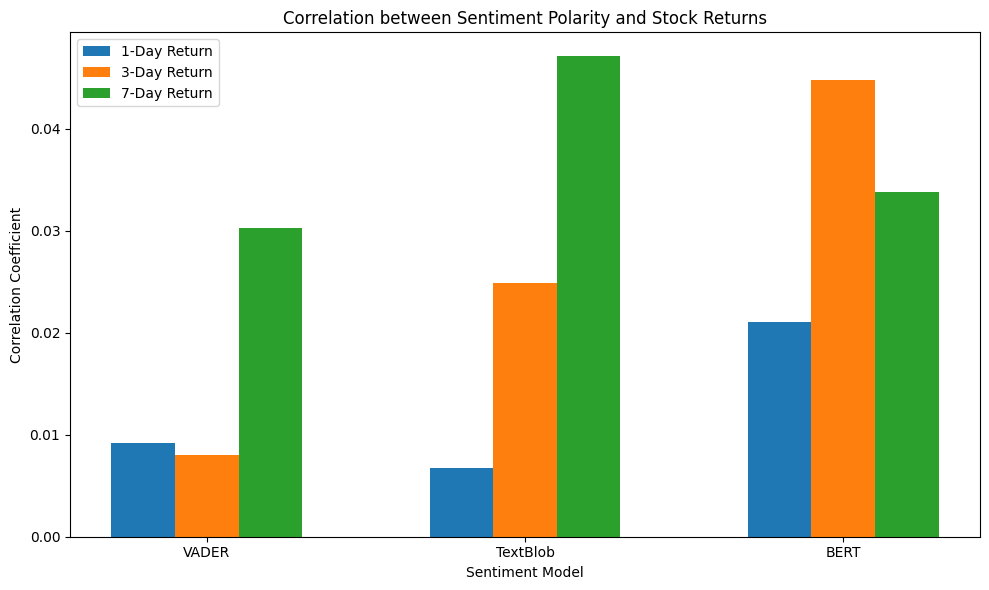

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Correlation results
models = ['VADER', 'TextBlob', 'BERT']
correlation_1_day = [correlation_vader_1_day, correlation_textblob_1_day, correlation_bert_1_day]
correlation_3_day = [correlation_vader_3_day, correlation_textblob_3_day, correlation_bert_3_day]
correlation_7_day = [correlation_vader_7_day, correlation_textblob_7_day, correlation_bert_7_day]

# Plot the bar chart
x = np.arange(len(models))  # the label locations

width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each timeframe
rects1 = ax.bar(x - width, correlation_1_day, width, label='1-Day Return')
rects2 = ax.bar(x, correlation_3_day, width, label='3-Day Return')
rects3 = ax.bar(x + width, correlation_7_day, width, label='7-Day Return')

# Add labels, title, and axes formatting
ax.set_xlabel('Sentiment Model')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Correlation between Sentiment Polarity and Stock Returns')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Function to classify returns based on magnitude (this remains the same)
def classify_return(return_value):
    if return_value > 0.05:
        return 'Large Positive Return'
    elif 0.02 <= return_value <= 0.05:
        return 'Medium Positive Return'
    elif 0 <= return_value < 0.02:
        return 'Small Positive Return'
    elif -0.02 <= return_value < 0:
        return 'Small Negative Return'
    elif -0.05 <= return_value < -0.02:
        return 'Medium Negative Return'
    else:
        return 'Large Negative Return'

# Apply the function to classify returns for different time periods
df['1_DAY_RETURN_CATEGORY'] = df['1_DAY_RETURN'].apply(classify_return)
df['3_DAY_RETURN_CATEGORY'] = df['3_DAY_RETURN'].apply(classify_return)
df['7_DAY_RETURN_CATEGORY'] = df['7_DAY_RETURN'].apply(classify_return)

# Check the classification results
df[['1_DAY_RETURN', '1_DAY_RETURN_CATEGORY']].head()


,1_DAY_RETURN,1_DAY_RETURN_CATEGORY
2,0.002011,Small Positive Return
3,0.002011,Small Positive Return
4,0.002011,Small Positive Return
11,0.012314,Small Positive Return
20,0.002011,Small Positive Return


In [ ]:
# Define a dictionary to hold the features (polarity scores)
polarity_models = {
    'BERT': 'BERT_POLARITY',
    'VADER': 'VADER_POLARITY',
    'TextBlob': 'TEXTBLOB_POLARITY'
}

# Define the target return categories
return_categories = {
    '1 Day Return': '1_DAY_RETURN_CATEGORY',
    '3 Day Return': '3_DAY_RETURN_CATEGORY',
    '7 Day Return': '7_DAY_RETURN_CATEGORY'
}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define a function to run classification for each polarity model and return category
def run_classification(polarity_model, return_category):
    # Select the polarity model as the feature
    X = df[[polarity_model]]

    # Target is the return category (1-day, 3-day, or 7-day)
    y = df[return_category]

    # Split the data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report


In [ ]:
# Store results in a dictionary
results = {}

# Loop through each polarity model and return category
for model_name, polarity_feature in polarity_models.items():
    for return_period, return_category in return_categories.items():
        # Run the classification and get the accuracy and report
        accuracy, report = run_classification(polarity_feature, return_category)

        # Store the results
        results[f'{model_name} - {return_period}'] = {
            'accuracy': accuracy,
            'report': report
        }


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Display the results
for model_return, metrics in results.items():
    print(f"Model: {model_return}")
    print(f"Accuracy: {metrics['accuracy'] * 100:.2f}%")
    print(f"Classification Report:\n{metrics['report']}\n")


Model: BERT - 1 Day Return
Accuracy: 57.76%
Classification Report:
                        precision    recall  f1-score   support

 Large Negative Return       0.34      0.40      0.37        25
 Large Positive Return       0.30      0.26      0.28        99
Medium Negative Return       0.48      0.50      0.49       389
Medium Positive Return       0.40      0.42      0.41       456
 Small Negative Return       0.50      0.52      0.51      1416
 Small Positive Return       0.68      0.66      0.67      2646

              accuracy                           0.58      5031
             macro avg       0.45      0.46      0.46      5031
          weighted avg       0.58      0.58      0.58      5031


Model: BERT - 3 Day Return
Accuracy: 50.73%
Classification Report:
                        precision    recall  f1-score   support

 Large Negative Return       0.43      0.46      0.44       101
 Large Positive Return       0.33      0.29      0.30       175
Medium Negative Return       

In [ ]:
import pandas as pd

# Initialize an empty dictionary to store the accuracies
accuracy_summary = {
    '1 Day Return': [],
    '3 Day Return': [],
    '7 Day Return': []
}

# Loop through each polarity model
for model_name in polarity_models.keys():
    # Extract accuracy for each return period and store it in the corresponding list
    for return_period in return_categories.keys():
        accuracy_summary[return_period].append(results[f'{model_name} - {return_period}']['accuracy'] * 100)

# Create a pandas DataFrame from the dictionary
accuracy_df = pd.DataFrame(accuracy_summary, index=polarity_models.keys())

# Display the accuracy summary table
print("Summary Table of Overall Accuracy (%):")
print(accuracy_df)


Summary Table of Overall Accuracy (%):
          1 Day Return  3 Day Return  7 Day Return
BERT         57.761876     50.725502     47.903001
VADER        54.084675     40.051680     33.651362
TextBlob     53.408865     38.779567     30.490956


Accuracy Summary Table:
          1 Day Return  3 Day Return  7 Day Return
BERT         57.761876     50.725502     47.903001
VADER        54.084675     40.051680     33.651362
TextBlob     53.408865     38.779567     30.490956


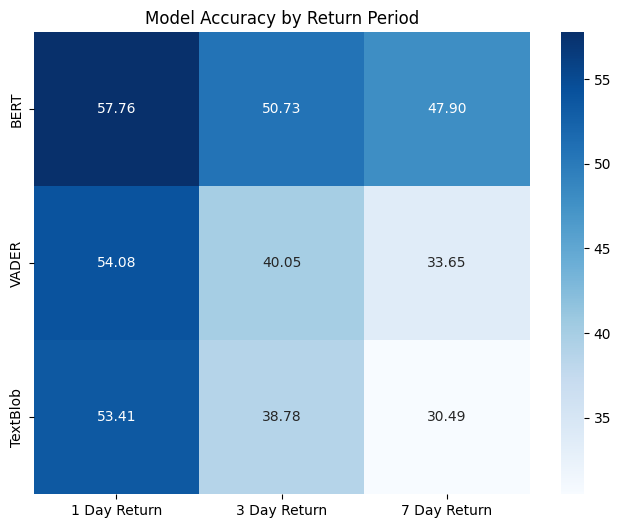

In [ ]:
# Print the summary table
print("Accuracy Summary Table:")
print(accuracy_df)

# You can also visualize it using a heatmap for better comparison (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Model Accuracy by Return Period')
plt.show()


# 7. Fine Tunning

### 7.1 Textblob

In [ ]:
from textblob import TextBlob

# Fine-tuned TextBlob polarity calculation
def fine_tuned_textblob_polarity(text):
    blob = TextBlob(text)

    # Extract polarity and subjectivity
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    # Adjust polarity based on subjectivity (optional)
    # For example, downweight polarity if it's very subjective
    if subjectivity > 0.5:
        polarity = polarity * 0.5

    # Handling negations (simplified example)
    if "not" in text.split():
        polarity = -polarity

    return polarity

# Apply the fine-tuned function to calculate TextBlob polarity
df['FINE_TUNED_TEXTBLOB_POLARITY'] = df['CLEANED_TWEET'].apply(fine_tuned_textblob_polarity)

# Check the results
df[['CLEANED_TWEET', 'FINE_TUNED_TEXTBLOB_POLARITY']].head()


,CLEANED_TWEET,FINE_TUNED_TEXTBLOB_POLARITY
2,jamaicans make money with and \r,0.0
3,jamaicans make money with and \r,0.0
4,jamaicans make money with and \r,0.0
11,rt thank you ceo for committing to hire 1000...,0.2
20,jamaicans make money with and \r,0.0


In [ ]:
FINE_TUNED_TEXTBLOB_POLARITY_counts = df['FINE_TUNED_TEXTBLOB_POLARITY'].value_counts()

print("Frequency of each polarity:")
print(FINE_TUNED_TEXTBLOB_POLARITY_counts)

Frequency of each polarity:
FINE_TUNED_TEXTBLOB_POLARITY
 0.000000    11138
 0.500000      804
 0.250000      794
 0.200000      783
 0.136364      592
             ...  
 0.237500        1
-0.400000        1
-0.215385        1
 0.120000        1
 0.043333        1
Name: count, Length: 1307, dtype: int64


### 7.2 VADER

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Adding financial terms to VADER lexicon
new_words = {
    'bullish': 2.0,  # Strong positive sentiment
    'bearish': -2.0,  # Strong negative sentiment
    'profit': 1.5,  # Positive term
    'loss': -1.5,  # Negative term
    'earnings beat': 2.5,  # Strong positive financial term
    'missed guidance': -2.5  # Strong negative financial term
}

vader_analyzer.lexicon.update(new_words)

# Fine-tuned VADER polarity function
def fine_tuned_vader_polarity(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']  # Return compound sentiment score

# Apply the fine-tuned VADER function to calculate polarity
df['FINE_TUNED_VADER_POLARITY'] = df['CLEANED_TWEET'].apply(fine_tuned_vader_polarity)

# Check the results
df[['CLEANED_TWEET', 'FINE_TUNED_VADER_POLARITY']].head()


,CLEANED_TWEET,FINE_TUNED_VADER_POLARITY
2,jamaicans make money with and \r,0.0000
3,jamaicans make money with and \r,0.0000
4,jamaicans make money with and \r,0.0000
11,rt thank you ceo for committing to hire 1000...,0.6908
20,jamaicans make money with and \r,0.0000


### 7.3 FinBert

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Load the FinBERT tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

# Function to calculate FinBERT polarity
def finbert_polarity(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    scores = outputs.logits.detach().numpy()
    scores = softmax(scores, axis=1)  # Apply softmax to get probabilities
    positive_score = scores[0][2]
    negative_score = scores[0][0]

    # Define polarity as the difference between positive and negative scores
    polarity = positive_score - negative_score
    return polarity

# Monitor the process using tqdm
tqdm.pandas()  # Activate the tqdm progress bar for pandas apply

# Apply the FinBERT polarity function with progress bar
df['FINBERT_POLARITY'] = df['CLEANED_TWEET'].progress_apply(finbert_polarity)

# Check the results
df[['CLEANED_TWEET', 'FINBERT_POLARITY']].head()



config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

100%|██████████| 25153/25153 [20:58<00:00, 19.98it/s]


,CLEANED_TWEET,FINBERT_POLARITY
2,jamaicans make money with and \r,-0.999235
3,jamaicans make money with and \r,-0.999235
4,jamaicans make money with and \r,-0.999235
11,rt thank you ceo for committing to hire 1000...,-0.325019
20,jamaicans make money with and \r,-0.999235


# 8. Link to return

FinBERT polarity matches 1-day return direction: 54.84%
Fine-tuned VADER polarity matches 1-day return direction: 46.29%
Fine-tuned TextBlob polarity matches 1-day return direction: 45.81%
FinBERT polarity matches 3-day return direction: 45.26%
Fine-tuned VADER polarity matches 3-day return direction: 53.32%
Fine-tuned TextBlob polarity matches 3-day return direction: 54.92%
FinBERT polarity matches 7-day return direction: 45.46%
Fine-tuned VADER polarity matches 7-day return direction: 51.99%
Fine-tuned TextBlob polarity matches 7-day return direction: 54.43%


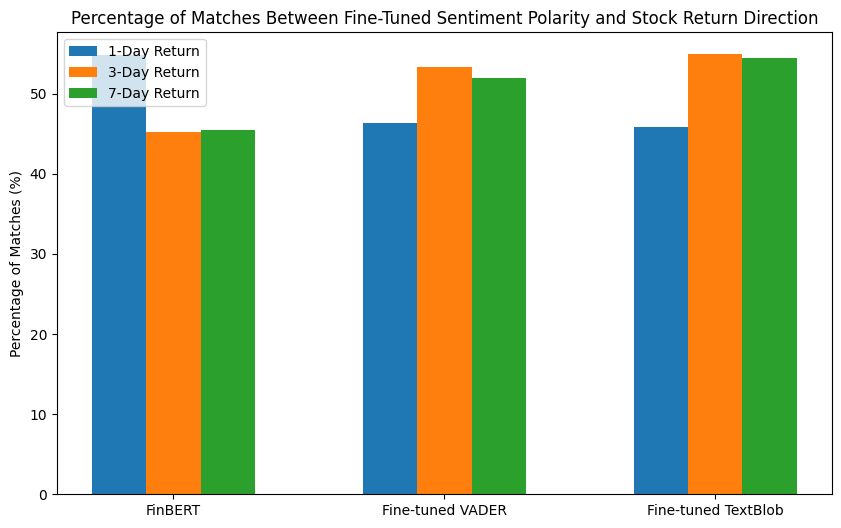

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume you have a DataFrame 'df' with fine-tuned polarity scores and stock returns

# Create a binary label for fine-tuned sentiment polarity
# 1 for positive polarity (>= 0), 0 for negative polarity (< 0)
df['FINBERT_POLARITY_SIGN'] = df['FINBERT_POLARITY'].apply(lambda x: 1 if x >= 0 else 0)
df['FINE_TUNED_VADER_POLARITY_SIGN'] = df['FINE_TUNED_VADER_POLARITY'].apply(lambda x: 1 if x >= 0 else 0)
df['FINE_TUNED_TEXTBLOB_POLARITY_SIGN'] = df['FINE_TUNED_TEXTBLOB_POLARITY'].apply(lambda x: 1 if x >= 0 else 0)

# Create a binary label for stock returns
# 1 for positive return (> 0), 0 for negative or no return (<= 0)
df['1_DAY_RETURN_SIGN'] = df['1_DAY_RETURN'].apply(lambda x: 1 if x > 0 else 0)
df['3_DAY_RETURN_SIGN'] = df['3_DAY_RETURN'].apply(lambda x: 1 if x > 0 else 0)
df['7_DAY_RETURN_SIGN'] = df['7_DAY_RETURN'].apply(lambda x: 1 if x > 0 else 0)

# Compare signs for 1-day return for fine-tuned models
matches_finbert_1_day = (df['FINBERT_POLARITY_SIGN'] == df['1_DAY_RETURN_SIGN']).mean()
matches_fine_tuned_vader_1_day = (df['FINE_TUNED_VADER_POLARITY_SIGN'] == df['1_DAY_RETURN_SIGN']).mean()
matches_fine_tuned_textblob_1_day = (df['FINE_TUNED_TEXTBLOB_POLARITY_SIGN'] == df['1_DAY_RETURN_SIGN']).mean()

# Compare signs for 3-day return for fine-tuned models
matches_finbert_3_day = (df['FINBERT_POLARITY_SIGN'] == df['3_DAY_RETURN_SIGN']).mean()
matches_fine_tuned_vader_3_day = (df['FINE_TUNED_VADER_POLARITY_SIGN'] == df['3_DAY_RETURN_SIGN']).mean()
matches_fine_tuned_textblob_3_day = (df['FINE_TUNED_TEXTBLOB_POLARITY_SIGN'] == df['3_DAY_RETURN_SIGN']).mean()

# Compare signs for 7-day return for fine-tuned models
matches_finbert_7_day = (df['FINBERT_POLARITY_SIGN'] == df['7_DAY_RETURN_SIGN']).mean()
matches_fine_tuned_vader_7_day = (df['FINE_TUNED_VADER_POLARITY_SIGN'] == df['7_DAY_RETURN_SIGN']).mean()
matches_fine_tuned_textblob_7_day = (df['FINE_TUNED_TEXTBLOB_POLARITY_SIGN'] == df['7_DAY_RETURN_SIGN']).mean()

# Print the percentage of matches for each model (FinBERT, fine-tuned VADER, fine-tuned TextBlob)
print(f"FinBERT polarity matches 1-day return direction: {matches_finbert_1_day * 100:.2f}%")
print(f"Fine-tuned VADER polarity matches 1-day return direction: {matches_fine_tuned_vader_1_day * 100:.2f}%")
print(f"Fine-tuned TextBlob polarity matches 1-day return direction: {matches_fine_tuned_textblob_1_day * 100:.2f}%")

print(f"FinBERT polarity matches 3-day return direction: {matches_finbert_3_day * 100:.2f}%")
print(f"Fine-tuned VADER polarity matches 3-day return direction: {matches_fine_tuned_vader_3_day * 100:.2f}%")
print(f"Fine-tuned TextBlob polarity matches 3-day return direction: {matches_fine_tuned_textblob_3_day * 100:.2f}%")

print(f"FinBERT polarity matches 7-day return direction: {matches_finbert_7_day * 100:.2f}%")
print(f"Fine-tuned VADER polarity matches 7-day return direction: {matches_fine_tuned_vader_7_day * 100:.2f}%")
print(f"Fine-tuned TextBlob polarity matches 7-day return direction: {matches_fine_tuned_textblob_7_day * 100:.2f}%")

# Visualization of match percentages
# Create lists of match percentages for 1-day, 3-day, and 7-day returns for fine-tuned models
match_1_day = [matches_finbert_1_day * 100, matches_fine_tuned_vader_1_day * 100, matches_fine_tuned_textblob_1_day * 100]
match_3_day = [matches_finbert_3_day * 100, matches_fine_tuned_vader_3_day * 100, matches_fine_tuned_textblob_3_day * 100]
match_7_day = [matches_finbert_7_day * 100, matches_fine_tuned_vader_7_day * 100, matches_fine_tuned_textblob_7_day * 100]

# Create a bar plot
models = ['FinBERT', 'Fine-tuned VADER', 'Fine-tuned TextBlob']
x = range(len(models))

plt.figure(figsize=(10, 6))

# Bar plot for 1-day, 3-day, and 7-day match percentages
plt.bar(x, match_1_day, width=0.2, label='1-Day Return', align='center')
plt.bar([i + 0.2 for i in x], match_3_day, width=0.2, label='3-Day Return', align='center')
plt.bar([i + 0.4 for i in x], match_7_day, width=0.2, label='7-Day Return', align='center')

# Formatting the plot
plt.xticks([i + 0.2 for i in x], models)
plt.ylabel('Percentage of Matches (%)')
plt.title('Percentage of Matches Between Fine-Tuned Sentiment Polarity and Stock Return Direction')
plt.legend()

plt.show()


In [ ]:
# Define a dictionary to hold the features (polarity scores)
fine_tuned_polarity_models = {
    'FinBERT': 'FINBERT_POLARITY',
    'Fine-tuned VADER': 'FINE_TUNED_VADER_POLARITY',
    'Fine-tuned TextBlob': 'FINE_TUNED_TEXTBLOB_POLARITY'
}

# Define the target return categories
return_categories = {
    '1 Day Return': '1_DAY_RETURN_CATEGORY',
    '3 Day Return': '3_DAY_RETURN_CATEGORY',
    '7 Day Return': '7_DAY_RETURN_CATEGORY'
}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Function to run Random Forest classification
def run_random_forest(polarity_model, return_category):
    # Select the polarity model as the feature
    X = df[[polarity_model]]

    # Target is the return category (1-day, 3-day, or 7-day)
    y = df[return_category]

    # Split the data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report


In [ ]:
# Store results in a dictionary
random_forest_results = {}

# Loop through each polarity model and return category
for model_name, polarity_feature in fine_tuned_polarity_models.items():
    for return_period, return_category in return_categories.items():
        # Run the Random Forest classifier
        accuracy, report = run_random_forest(polarity_feature, return_category)

        # Store the results
        random_forest_results[f'{model_name} - {return_period}'] = {
            'accuracy': accuracy,
            'report': report
        }


In [ ]:
# Display the Random Forest classification results
for model_return, metrics in random_forest_results.items():
    print(f"Model: {model_return}")
    print(f"Accuracy: {metrics['accuracy'] * 100:.2f}%")
    print(f"Classification Report:\n{metrics['report']}\n")


Model: FinBERT - 1 Day Return
Accuracy: 56.71%
Classification Report:
                        precision    recall  f1-score   support

 Large Negative Return       0.56      0.20      0.29        25
 Large Positive Return       0.38      0.23      0.29        99
Medium Negative Return       0.47      0.46      0.47       389
Medium Positive Return       0.41      0.33      0.36       456
 Small Negative Return       0.49      0.39      0.43      1416
 Small Positive Return       0.63      0.73      0.68      2646

              accuracy                           0.57      5031
             macro avg       0.49      0.39      0.42      5031
          weighted avg       0.55      0.57      0.56      5031


Model: FinBERT - 3 Day Return
Accuracy: 48.12%
Classification Report:
                        precision    recall  f1-score   support

 Large Negative Return       0.49      0.35      0.40       101
 Large Positive Return       0.39      0.22      0.28       175
Medium Negative Return 

In [ ]:
# Initialize an empty dictionary to store the accuracies
random_forest_accuracy_summary = {
    '1 Day Return': [],
    '3 Day Return': [],
    '7 Day Return': []
}

# Extract accuracy for each model and return period
for model_name in fine_tuned_polarity_models.keys():
    for return_period in return_categories.keys():
        random_forest_accuracy_summary[return_period].append(random_forest_results[f'{model_name} - {return_period}']['accuracy'] * 100)

# Create a pandas DataFrame to store the summary
random_forest_accuracy_df = pd.DataFrame(random_forest_accuracy_summary, index=fine_tuned_polarity_models.keys())

# Display the summary table
print("Random Forest Accuracy Summary Table:")
print(random_forest_accuracy_df)



Random Forest Accuracy Summary Table:
                     1 Day Return  3 Day Return  7 Day Return
FinBERT                 56.708408     48.121646     42.635659
Fine-tuned VADER        53.925661     40.051680     33.631485
Fine-tuned TextBlob     53.548002     38.660306     31.146889


Accuracy Summary Table:
          1 Day Return  3 Day Return  7 Day Return
BERT         57.761876     50.725502     47.903001
VADER        54.084675     40.051680     33.651362
TextBlob     53.408865     38.779567     30.490956


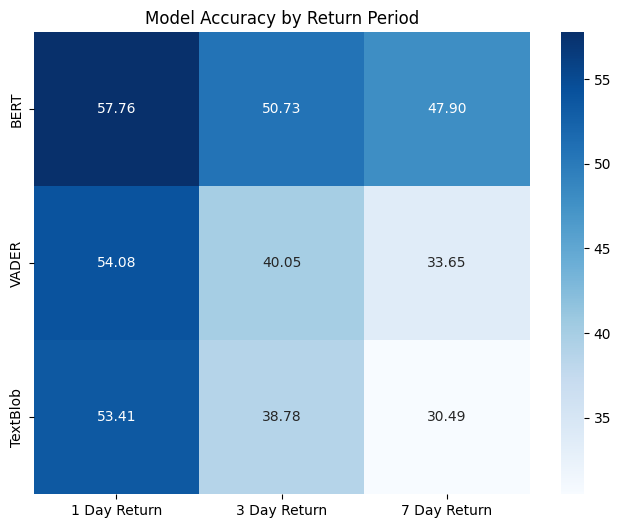

In [ ]:
# Print the summary table
print("Accuracy Summary Table:")
print(accuracy_df)

# You can also visualize it using a heatmap for better comparison (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_df, annot=True, cmap="Blues", fmt=".2f")
plt.title('Model Accuracy by Return Period')
plt.show()

# 9. comparison between the fine tunned and non fine tuned model

In [ ]:
# Define a dictionary to hold both non-fine-tuned and fine-tuned features (polarity scores)
all_polarity_models = {
    'BERT': 'BERT_POLARITY',
    'VADER': 'VADER_POLARITY',
    'TextBlob': 'TEXTBLOB_POLARITY',
    'FinBERT': 'FINBERT_POLARITY',
    'Fine-tuned VADER': 'FINE_TUNED_VADER_POLARITY',
    'Fine-tuned TextBlob': 'FINE_TUNED_TEXTBLOB_POLARITY'
}

# Define the target return categories
return_categories = {
    '1 Day Return': '1_DAY_RETURN_CATEGORY',
    '3 Day Return': '3_DAY_RETURN_CATEGORY',
    '7 Day Return': '7_DAY_RETURN_CATEGORY'
}


In [ ]:
# Store results in a dictionary
all_random_forest_results = {}

# Loop through each polarity model and return category
for model_name, polarity_feature in all_polarity_models.items():
    for return_period, return_category in return_categories.items():
        # Run the Random Forest classifier
        accuracy, report = run_random_forest(polarity_feature, return_category)

        # Store the results
        all_random_forest_results[f'{model_name} - {return_period}'] = {
            'accuracy': accuracy,
            'report': report
        }


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Initialize an empty dictionary to store the accuracies for all models
all_random_forest_accuracy_summary = {
    '1 Day Return': [],
    '3 Day Return': [],
    '7 Day Return': []
}

# Extract accuracy for each model and return period
for model_name in all_polarity_models.keys():
    for return_period in return_categories.keys():
        all_random_forest_accuracy_summary[return_period].append(all_random_forest_results[f'{model_name} - {return_period}']['accuracy'] * 100)

# Create a pandas DataFrame to store the summary
all_random_forest_accuracy_df = pd.DataFrame(all_random_forest_accuracy_summary, index=all_polarity_models.keys())

# Display the summary table
print("Random Forest Accuracy Summary Table (All Models):")
print(all_random_forest_accuracy_df)


Random Forest Accuracy Summary Table (All Models):
                     1 Day Return  3 Day Return  7 Day Return
BERT                    57.761876     50.725502     47.903001
VADER                   54.084675     40.051680     33.651362
TextBlob                53.408865     38.779567     30.490956
FinBERT                 56.708408     48.121646     42.635659
Fine-tuned VADER        53.925661     40.051680     33.631485
Fine-tuned TextBlob     53.548002     38.660306     31.146889


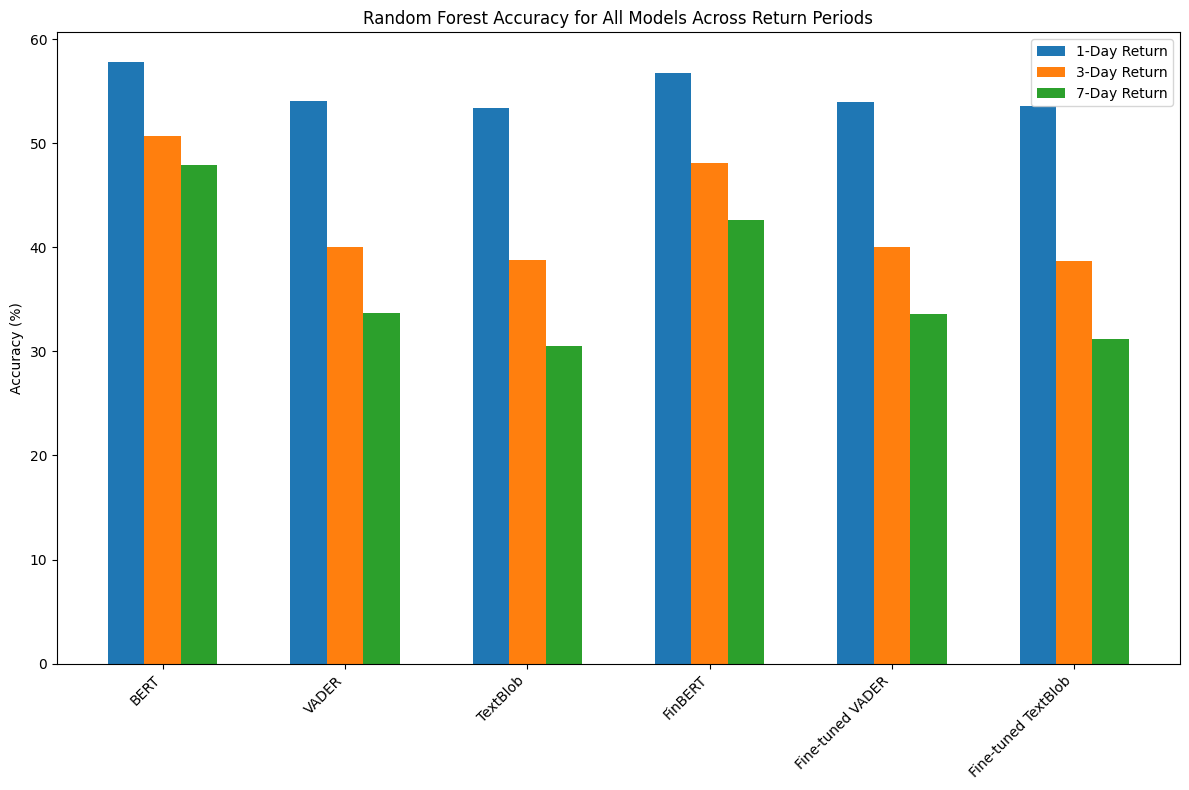

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot for each return period
models = list(all_polarity_models.keys())
x = range(len(models))

# Create lists for 1-day, 3-day, and 7-day accuracies
accuracy_1_day = all_random_forest_accuracy_df['1 Day Return'].values
accuracy_3_day = all_random_forest_accuracy_df['3 Day Return'].values
accuracy_7_day = all_random_forest_accuracy_df['7 Day Return'].values

plt.figure(figsize=(12, 8))

# Bar plot for 1-day, 3-day, and 7-day match percentages
plt.bar(x, accuracy_1_day, width=0.2, label='1-Day Return', align='center')
plt.bar([i + 0.2 for i in x], accuracy_3_day, width=0.2, label='3-Day Return', align='center')
plt.bar([i + 0.4 for i in x], accuracy_7_day, width=0.2, label='7-Day Return', align='center')

# Formatting the plot
plt.xticks([i + 0.2 for i in x], models, rotation=45, ha="right")
plt.ylabel('Accuracy (%)')
plt.title('Random Forest Accuracy for All Models Across Return Periods')
plt.legend()

plt.tight_layout()
plt.show()


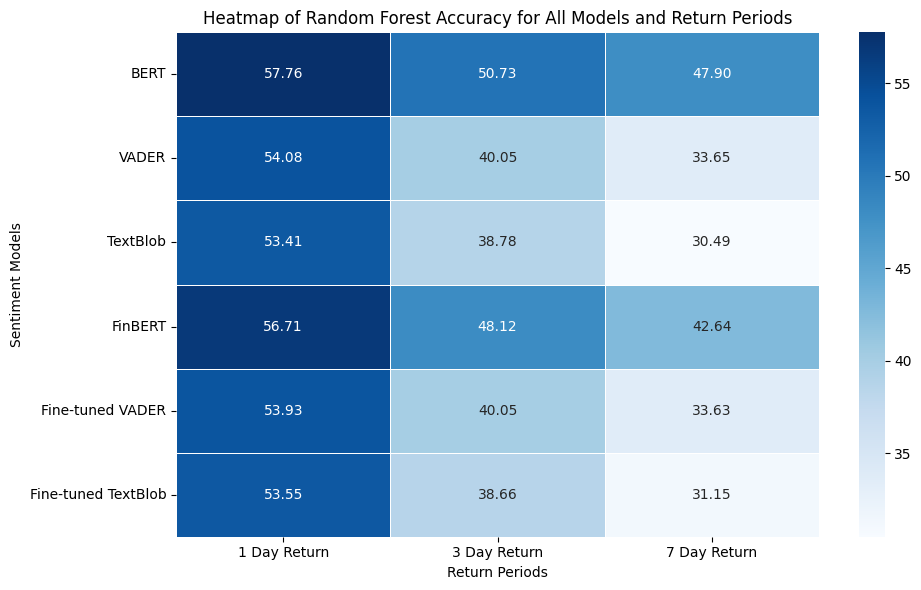

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap from the summary DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(all_random_forest_accuracy_df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)

# Add labels and title
plt.title('Heatmap of Random Forest Accuracy for All Models and Return Periods')
plt.ylabel('Sentiment Models')
plt.xlabel('Return Periods')

plt.tight_layout()
plt.show()
